# Predicting Doctor Appointment No-Shows
***

## Table of Contents
* [Reloading](#reloading)
* [Introduction](#introduction)
* [Data Wrangling](#data_wrangling)
    * [General Properties](#general_properties)
    * [Data Cleaning](#data_cleaning)
        * [Checking for Duplicates](#cleaning_duplicates)
        * [Appointment ID](#cleaning_appointment_id)
        * [Scheduled Day](#cleaning_scheduled_day)
        * [Appointment Day](#cleaning_appointment_day)
        * [Gender](#cleaning_gender)
        * [Age](#cleaning_age)
        * [Bolsa Familia](#cleaning_bolsa_familia)
        * [Hypertension](#cleaning_hypertension)
        * [Diabetes](#cleaning_diabetes)
        * [Number of Handicaps](#cleaning_number_handicaps)
        * [SMS Received](#cleaning_sms_received)
        * [No Show](#cleaning_no_show)
        * [Neighborhood](#cleaning_neighborhood)
        * [Patient ID](#cleaning_patient_id)
            * [Patient ID Consistency](#cleaning_patient_id_consistency)
* [Additional Data](#addtl_data)
* [Feature Engineering](#feat_engineering)
* [Initial Exploration and Further Cleaning](#further_cleaning)
* [Exploratory Data Analysis](#eda)
    * [Univariate](#univariate)
    * [By Attendance](#by_attendance)

<a id='introduction'></a>

## Introduction
***

In this project, my aim is to determine what patient characteristics are connected with not showing up to a doctor's appointment by analyzing a data set of over 110K medical appointments in Vitória, Espírito Santo, Brazil provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

<a id='data_wrangling'></a>

## Data Wrangling
***

In [1]:
import pandas as pd
import numpy as np
import geocoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
from scipy.stats import chi2_contingency
from datetime import timedelta
import config
API_KEY = config.api_key

In [2]:
matplotlib.rcParams.update({'font.size': 12.5})

<a id='general_properties'></a>

### General Properties

In [3]:
orig = pd.read_csv('KaggleV2-May-2016.csv')
orig.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Number of records
n = len(orig)
n

110527

In [5]:
# Rename fields to have more consistent formatting and to English where appropriate
orig.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
              'AppointmentDay', 'Age', 'Neighborhood', 'BolsaFamilia', \
              'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps', \
              'SMSReceived', 'NoShow']

In [6]:
# Number of nulls
orig.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighborhood      0
BolsaFamilia      0
Hypertension      0
Diabetes          0
Alcoholism        0
NumHandicaps      0
SMSReceived       0
NoShow            0
dtype: int64

> There are no null records in any of the fields

In [7]:
# Data types
orig.dtypes

PatientID         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighborhood       object
BolsaFamilia        int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
NumHandicaps        int64
SMSReceived         int64
NoShow             object
dtype: object

<a id='data_cleaning'></a>

### Data Cleaning

<a id='cleaning_duplicates'></a>

#### Checking for Duplicates

In [8]:
orig.duplicated(keep=False).any()

False

In [9]:
orig.duplicated('AppointmentID', keep=False).any()

False

> There are no duplicate entries and no duplicate AppointmentIDs.

<a id='cleaning_appointment_id'></a>

#### Appointment ID

In [10]:
min_apptID = orig['AppointmentID'].min()
max_apptID = orig['AppointmentID'].max()
print('{} - {}'.format(min_apptID, max_apptID))

5030230 - 5790484


> All of the appointment IDs are 7 digits long, and are between these values

In [11]:
# AppointmentIDs are identifiers, so they are also converted to strings
orig['AppointmentID'] = orig['AppointmentID'].astype(str)

<a id='cleaning_scheduled_day'></a>

#### Scheduled Day
ScheduledDay represents the day that a patient created the appointment.

In [12]:
# Convert the scheduled day to a datetime
orig['ScheduledDay'] = pd.to_datetime(orig['ScheduledDay'])

# Verify that ScheduledDay is in a datetime format
orig['ScheduledDay'].dtype

dtype('<M8[ns]')

In [13]:
# Check that the <M8[ns] is a datetime format
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [14]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['ScheduledDay']).sum()

0

In [15]:
# Include a field for scheduled day in a date format
orig['ScheduledDayDate'] = orig['ScheduledDay'].dt.date

In [16]:
# The first date and time an appointment was scheduled 
np.min(orig['ScheduledDay'])

Timestamp('2015-11-10 07:13:56')

In [17]:
# The last date and time an appointment was scheduled 
np.max(orig['ScheduledDay'])

Timestamp('2016-06-08 20:07:23')

In [18]:
np.max(orig['ScheduledDay']) - np.min(orig['ScheduledDay'])

Timedelta('211 days 12:53:27')

> All appointments are created within an about 7-month time frame.

In [19]:
# Create a field for the hour the appointment was scheduled rounded to the nearest hour
def round_time(dt, roundTo=60*60, fmt='%-H'):
    # Author: Thierry Husson 2012
    dt = dt.to_pydatetime()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    time = dt + timedelta(0,rounding-seconds,-dt.microsecond)
    return int(time.strftime(fmt))

orig['ScheduledHour'] = orig['ScheduledDay'].apply(lambda x: round_time(x))

In [99]:
hour_counts = orig['ScheduledHour'].value_counts()
hour_counts.sort_index()

6        25
7     11526
8     17208
9     14087
10    11817
11    10039
12     6479
13     6767
14     9730
15     8507
16     7163
17     4093
18     1983
19      825
20      252
21       25
Name: ScheduledHour, dtype: int64

Most of the appointments were made during the morning and a much smaller portion were made after 6pm.

<a id='cleaning_appointment_day'></a>

#### Appointment Day
AppointmentDay is the day of the doctor's appointment.

In [20]:
# Convert the appointment day to a datetime
orig['AppointmentDay'] = pd.to_datetime(orig['AppointmentDay'])

# Verify that AppointmentDay is in a datetime format
orig['AppointmentDay'].dtype

dtype('<M8[ns]')

In [21]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['AppointmentDay']).sum()

0

In [22]:
# Since appointment day doesn't have a time, include another field for 
# it in a date format
orig['AppointmentDayDate'] = orig['AppointmentDay'].dt.date

# The first scheduled appointment
np.min(orig['AppointmentDay'])

Timestamp('2016-04-29 00:00:00')

In [23]:
# The last scheduled appointment
np.max(orig['AppointmentDay'])

Timestamp('2016-06-08 00:00:00')

In [24]:
np.max(orig['AppointmentDay']) - np.min(orig['AppointmentDay'])

Timedelta('40 days 00:00:00')

> While the appointments were scheduled during a 7-month period, they all were scheduled for a 40-day period.

<a id='cleaning_gender'></a>

#### Gender

In [25]:
# Gender data is clean
orig['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [26]:
# Encode gender as binary, 0 = male, 1 = female 
orig['Gender'] = np.where(orig['Gender'].values == 'F', 1, 0)
orig['Gender'].value_counts()

1    71840
0    38687
Name: Gender, dtype: int64

<a id='cleaning_age'></a>

#### Age

In [27]:
age_counts = orig['Age'].value_counts()
age_counts.index.sort_values()

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
             93,  94,  95,  96,  97,  98,  99, 100, 102, 115],
           dtype='int64', length=104)

In [28]:
orig.loc[orig['Age'] == -1]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow,ScheduledDayDate,ScheduledHour,AppointmentDayDate
99832,4.659432e+14,5775010,1,2016-06-06 08:58:13,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No,2016-06-06,9,2016-06-06


In [29]:
# Drop the record with an age of -1
invalid_age = orig.loc[orig['Age'] == -1, 'PatientID']
orig.drop(invalid_age.index, inplace=True)

> I removed the record with the age of -1.  All of the other ages are plausible; although the age of 115 is improbable, it is still possible.

<a id='cleaning_bolsa_familia'></a>

#### Bolsa Família

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program in Brazil.  A value of 1 for this field means that the patient receives financial aid from the Brazilian government under this progrm.

In [30]:
# BolsaFamilia data is clean
orig['BolsaFamilia'].value_counts()

0    99665
1    10861
Name: BolsaFamilia, dtype: int64

<a id='cleaning_hypertension'></a>

#### Hypertension

In [31]:
# Hypertension data is clean
orig['Hypertension'].value_counts()

0    88725
1    21801
Name: Hypertension, dtype: int64

<a id='cleaning_diabetes'></a>

#### Diabetes

In [32]:
# Diabetes data is clean
orig['Diabetes'].value_counts()

0    102583
1      7943
Name: Diabetes, dtype: int64

<a id='cleaning_alcoholism'></a>

#### Alcholism

In [33]:
# Alcoholism data is clean
orig['Alcoholism'].value_counts()

0    107166
1      3360
Name: Alcoholism, dtype: int64

<a id='cleaning_number_handicaps'></a>

#### Number of Handicaps

In [34]:
# This represents the number of handicaps a person has (as defined by the publisher of the dataset)
# All people having between 0-4 handicaps seems reasonable
orig['NumHandicaps'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: NumHandicaps, dtype: int64

Note that the data set does not define what are considered handicaps. Since there are so few patients that have handicaps, I created a binary field, HasHandicaps, that indicates whether or not a patient has any handicaps.

In [35]:
orig['HasHandicaps'] = np.where(orig['NumHandicaps'] == 0, 0, 1)
orig['HasHandicaps'].value_counts()

0    108285
1      2241
Name: HasHandicaps, dtype: int64

<a id='cleaning_sms_received'></a>

#### SMS Received
This field indicates whether or not a patient was sent an appointment reminder by the facility in the form of a text message.

In [36]:
# SMS Received data is clean
orig['SMSReceived'].value_counts()

0    75044
1    35482
Name: SMSReceived, dtype: int64

<a id='cleaning_no_show'></a>

#### No Show

A value of yes for NoShow means that the patient did not show up to their appointment (they were a 'no show').

In [37]:
orig['NoShow'].value_counts()

No     88207
Yes    22319
Name: NoShow, dtype: int64

In [38]:
# Convert NoShow to zeros and ones
orig['NoShow'] = np.where(orig['NoShow'].values == 'Yes', 1, 0)
orig['NoShow'].value_counts()

0    88207
1    22319
Name: NoShow, dtype: int64

<a id='cleaning_neighborhood'></a>

#### Neighborhood

The Neighborhood field has the neighborhood of the doctor's facility.

In [39]:
neighborhood_counts = orig['Neighborhood'].value_counts()
neighborhood_counts[:11]

JARDIM CAMBURI       7717
MARIA ORTIZ          5805
RESISTÊNCIA          4431
JARDIM DA PENHA      3877
ITARARÉ              3514
CENTRO               3334
TABUAZEIRO           3132
SANTA MARTHA         3131
JESUS DE NAZARETH    2853
BONFIM               2773
SANTO ANTÔNIO        2746
Name: Neighborhood, dtype: int64

In [40]:
# Number of unique neighborhoods
orig['Neighborhood'].nunique()

81

In [41]:
# Organize the neighborhoods into a dataframe
geo = pd.DataFrame(neighborhood_counts.index, columns = ['neighborhood'])
geo.head()

,neighborhood
0,JARDIM CAMBURI
1,MARIA ORTIZ
2,RESISTÊNCIA
3,JARDIM DA PENHA
4,ITARARÉ


In [ ]:
# Geocode the neighborhood data
for i, row in geo.iterrows():
    # Use Bing    
    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'
    result = geocoder.bing(full_neighborhood, key=API_KEY)
    
    geo.at[i, 'status'] = result.status
    geo.at[i, 'lat'] = result.lat
    geo.at[i, 'lng'] = result.lng
    geo.at[i, 'bing_neighborhood'] = result.neighborhood
    geo.at[i, 'city'] = result.city
    geo.at[i, 'state'] = result.state
    geo.at[i, 'country'] = result.country
    
    # If Bing returns None for neighborhood, use Google
    if geo.at[i, 'bing_neighborhood'] is None or \
       geo.at[i, 'bing_neighborhood'] == 'None':
        result = geocoder.google(full_neighborhood)
        
        geo.at[i, 'status'] = result.status
        geo.at[i, 'lat'] = result.lat
        geo.at[i, 'lng'] = result.lng
        
        if result.county == 'Vitória': # Google uses county where Bing uses city
            geo.at[i, 'city'] = result.county
        geo.at[i, 'state'] = result.state
        if result.country == 'BR':
            geo.at[i, 'country'] = 'Brazil'

# Assign Nazareth manually
full_neighborhood = 'Nazareth' + ', Vitória, Espírito Santo, Brazil'
result = geocoder.google(full_neighborhood)
geo.at[73, 'status'] = result.status
geo.at[73, 'lat'] = result.lat
geo.at[73, 'lng'] = result.lng
geo.at[73, 'state'] = 'ES'

# Assign Centro manually
full_neighborhood = 'Centro' + ', Vitória, Espírito Santo, Brazil'
result = geocoder.google(full_neighborhood)
geo.at[5, 'status'] = result.status
geo.at[5, 'lat'] = result.lat
geo.at[5, 'lng'] = result.lng
geo.at[5, 'state'] = 'ES'

In [ ]:
geo.head(6)

In [ ]:
# Check that all the neighborhoods are unique
(geo['bing_neighborhood'].value_counts() == 1).all()

In [ ]:
# Check that each neighborhood returns a unique location
not any(geo.duplicated(['lat', 'lng']))

In [ ]:
# Verify that all of the locations are in Vitória, Espírito Santo, Brazil
print((geo['status'] == 'OK').all())
print((geo['city'] == 'Vitória').all())
print((geo['state'] == 'ES').all())
print((geo['country'] == 'Brazil').all())

<a id='cleaning_patient_id'></a>

#### Patient ID

In [42]:
# Convert patient ID to a string, as it is meant to be an identifier not a number
orig['PatientID'] = orig['PatientID'].astype(int).astype(str)

# All identifiers are 7-15 digits long, most have at least 10
lens = orig['PatientID'].apply(len)
pd.value_counts(lens)

14    39372
13    28319
15    24918
12    12835
11     4002
10      920
9       136
8        18
5         3
6         2
7         1
Name: PatientID, dtype: int64

> Most of the patient IDs are at least 10 digits long.  There is no consistent length for this field, and it is unknown, and impossible to know, if some of these patient identifiers are flawed.

<a id='cleaning_patient_id_consistency'></a>

##### PatientID Consistency

In [43]:
# Number of appointments per PatientID
num_appts_by_patient = orig.groupby('PatientID')['AppointmentID'].count()
num_appts_by_patient[:5]

PatientID
11111462625267     1
111124532532143    2
11114485119737     1
11116239871275     1
1111633122891      3
Name: AppointmentID, dtype: int64

There are multiple appointments for some patients, so I am checking that the information for each patient across the different appointments is the same.

In [44]:
# check that all patient characteristics are consistent across different appointments
attributes = ['Gender', 'BolsaFamilia', 'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps',
              'Neighborhood']
for a in attributes:
    unique_attrib_vals = orig.groupby('PatientID')[a].nunique()
    if len(unique_attrib_vals[unique_attrib_vals > 1]) == 0:
        print(a + ' is consistent')
    else:
        print(a + ' is NOT consistent')

Gender is consistent
BolsaFamilia is consistent
Hypertension is consistent
Diabetes is consistent
Alcoholism is consistent
NumHandicaps is consistent
Neighborhood is consistent


In [45]:
# Appointments occur with a 7-month period, so the entries for a patient's ages should be within a year of each other
unique_age_vals = orig.groupby('PatientID')['Age'].nunique()
not_unique_age_vals = unique_age_vals[unique_age_vals > 1]

# Patients with more than one appointment, all have less than 2 values for age
len(not_unique_age_vals[not_unique_age_vals > 2])

0

In [47]:
# Get the information for the patients with more than one age
patients_multiple_ages = list(not_unique_age_vals.index)
multiple_ages_info = orig[orig['PatientID'].isin(patients_multiple_ages)].sort_values('PatientID')

# Get the difference between each patient's ages
max_age = multiple_ages_info.groupby('PatientID')['Age'].max()
min_age = multiple_ages_info.groupby('PatientID')['Age'].min()
age_diff = max_age - min_age

# Each patient's ages are within one year of each other
if age_diff[age_diff <= 1].all():
    print('Ages are within one year')
else:
    print('Ages are not within a year')

Ages are within one year


<a id='addtl_data'></a>

## Additional Data
***

I obtained weather data for Vitória airport from [wunderground.com](https://www.wunderground.com/history/airport/SBVT/2016/4/29/DailyHistory.html) for the appointment dates in the data set.

In [48]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

,Date,temp_high,temp_avg,temp_low,humidity_high,humidity_avg,humidity_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,Datetime
0,2016-04-29,75,73,71,88,76,64,12,7,6,16,11,0.01,0,0,0,2016-04-29
1,2016-04-30,80,74,69,88,79,70,12,7,6,13,7,0.00,0,0,0,2016-04-30
2,2016-05-01,77,73,69,83,67,52,12,6,4,17,13,0.00,1,0,0,2016-05-01
3,2016-05-02,81,74,66,83,58,33,12,8,6,17,11,0.00,0,0,0,2016-05-02
4,2016-05-03,79,70,62,88,80,61,12,7,6,17,5,0.00,0,0,0,2016-05-03


In [49]:
all(weather['visibility_high'] == 12)

True

Since visibility_high is always valued at 12, this would be removed from the data set before doing any modeling.

In [50]:
# Merge appointment data with weather data
ow = pd.merge(orig, weather, left_on='AppointmentDayDate', right_on='Date', how='left')

# Remove the visibility_high field since it has the same value for every date
ow = ow.drop(['Date', 'Datetime', 'visibility_high'], axis = 1)

# Check there are no null values
all(ow.isnull().sum() == 0)

True

In [51]:
ow.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,humidity_avg,humidity_low,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog
0,29872499824296,5642903,1,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,76,64,7,6,16,11,0.01,0,0,0
1,558997776694438,5642503,0,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,76,64,7,6,16,11,0.01,0,0,0
2,4262962299951,5642549,1,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,76,64,7,6,16,11,0.01,0,0,0
3,867951213174,5642828,1,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,76,64,7,6,16,11,0.01,0,0,0
4,8841186448183,5642494,1,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,76,64,7,6,16,11,0.01,0,0,0


<a id='feat_engineering'></a>

## Feature Engineering
***

### Differences Between Scheduled and Appointment Days

In [52]:
# Add a field for the number of days between scheduling and the appointment
ow['DayDiff'] = ((ow['AppointmentDayDate'] - ow['ScheduledDayDate'])/np.timedelta64(1, 'D')).astype(int)
ow[['ScheduledDayDate', 'AppointmentDayDate', 'DayDiff']].sort_values(by = 'DayDiff')[:7]

,ScheduledDayDate,AppointmentDayDate,DayDiff
71533,2016-05-11,2016-05-05,-6
72362,2016-05-04,2016-05-03,-1
64175,2016-05-05,2016-05-04,-1
55226,2016-05-18,2016-05-17,-1
27033,2016-05-10,2016-05-09,-1
57785,2016-05-04,2016-05-04,0
57786,2016-05-18,2016-05-18,0


We can see that we need to do some data cleaning as there are five appointments that were shown to be scheduled days after the appointment itself.  These are obviously errors and since there are only five, they were removed from the data.

In [53]:
ow = (ow[ow['DayDiff'] >= 0])

In [54]:
# Create a field for a binned version of DayDiff
bins = [0, 1, 2, 3, 6, 11, 15, 30, 60, 100, 200]
day_diff_bin_labels = ['0', '1', '2', '3-5', '6-10', '11-14', '15-29', '30-59',
                       '60-99', '100+']
ow['DayDiffBin'] = pd.cut(ow['DayDiff'], bins, right = False, labels = day_diff_bin_labels)

ow['DayDiffBin'].value_counts().sort_index()

0        38562
1         5213
2         6725
3-5      11304
6-10     14271
11-14     6697
15-29    16667
30-59     8914
60-99     2030
100+       138
Name: DayDiffBin, dtype: int64

### Day of Week and Weekend

In [55]:
# Add a field for whether the AppointmentDay is during the weekend (1) or not (0)
ow['DayOfWeek'] = pd.to_datetime(ow['AppointmentDay']).dt.dayofweek
ow['Weekend'] = np.where(ow['DayOfWeek'] >= 5, 1, 0)

# Number of weekend appointments
ow['Weekend'].sum()

39

<a id='further_cleaning'></a>

## Initial Exploration and Further Cleaning

#### Number of appointments by patient

In [56]:
num_appts_by_patient.sort_values(ascending = False)[:10]

PatientID
822145925426128    88
99637671331        84
26886125921145     70
33534783483176     65
75797461494159     62
258424392677       62
871374938638855    62
6264198675331      62
66844879846766     57
872278549442       55
Name: AppointmentID, dtype: int64

> Oddly there are patients with a significant number of appointments.  The appointments only occurred during a 40-day period, so even if a patient had an appointment every day during this period, they would still only have a maximum of 40 appointments.

In [57]:
# Bin the number of appointments per patient
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 80]
bin_names = ["1", "2", "3", "4", "5", "6-10", "11-15", "16-20", "21-30", "31-40", "41-50", "50+"]

num_appts_binned = pd.cut(num_appts_by_patient, bins = bins, labels = bin_names).value_counts()
num_appts_binned.sort_index()

1        37919
2        13895
3         5500
4         2367
5         1119
6-10      1250
11-15      171
16-20       42
21-30       10
31-40        8
41-50        5
50+         10
Name: AppointmentID, dtype: int64

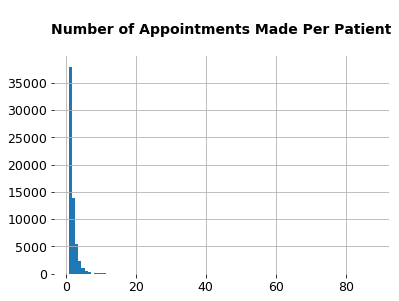

In [58]:
num_appts_by_patient.hist(bins = 100)
sns.despine(left = True, bottom = True)
plt.title("\nNumber of Appointments Made Per Patient\n", fontsize = 14, fontweight = 'bold');

The number of appointments is very skewed to the right.  The majority of patients made three or fewer appointments during this 40-day time period, but the data is very long tailed with up to 88 appointments per patient.

In [59]:
# Inspect the patient with 88 appointments
most_appts = ow[ow['PatientID'] == '822145925426128'].sort_values(by = 'ScheduledDay')
most_appts

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,DayDiffBin,DayOfWeek,Weekend
3006,822145925426128,5638995,0,2016-04-29 08:38:44,2016-04-29,38,REDENÇÃO,0,0,0,...,16,11,0.01,0,0,0,0,0,4,0
3093,822145925426128,5640809,0,2016-04-29 11:27:34,2016-04-29,38,REDENÇÃO,0,0,0,...,16,11,0.01,0,0,0,0,0,4,0
3060,822145925426128,5642878,0,2016-04-29 18:02:42,2016-04-29,38,REDENÇÃO,0,0,0,...,16,11,0.01,0,0,0,0,0,4,0
8707,822145925426128,5645183,0,2016-05-02 09:34:46,2016-05-02,38,REDENÇÃO,0,0,0,...,17,11,0.00,0,0,0,0,0,0,0
25428,822145925426128,5649058,0,2016-05-02 17:38:17,2016-05-02,38,REDENÇÃO,0,0,0,...,17,11,0.00,0,0,0,0,0,0,0
35675,822145925426128,5649163,0,2016-05-02 17:57:36,2016-05-02,38,REDENÇÃO,0,0,0,...,17,11,0.00,0,0,0,0,0,0,0
7685,822145925426128,5655382,0,2016-05-03 16:57:59,2016-05-03,38,REDENÇÃO,0,0,0,...,17,5,0.00,0,0,0,0,0,1,0
8831,822145925426128,5657205,0,2016-05-04 09:03:31,2016-05-04,38,REDENÇÃO,0,0,0,...,15,5,0.00,0,0,0,0,0,2,0
8450,822145925426128,5658723,0,2016-05-04 11:38:34,2016-05-04,38,REDENÇÃO,0,0,0,...,15,5,0.00,0,0,0,0,0,2,0
8465,822145925426128,5658733,0,2016-05-04 11:40:14,2016-05-04,38,REDENÇÃO,0,0,0,...,15,5,0.00,0,0,0,0,0,2,0


In [60]:
most_appts['NoShow'].sum()

1

> From analyzing this and other patients' appointments, I found that many appointments were made for a certain day, and then later another appointment was made for that same day.  We can see above that the patient made an appointment for April 29, three different times.  For the patient above, they made the appointments within farily quick succession of each other.  However other patients, as shown below, seemed to make appointments in advance and then as the appointment got closer rescheduled it.

In [61]:
ow[ow['PatientID'] == '99992299798515'].sort_values(by = 'ScheduledDay')

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,DayDiffBin,DayOfWeek,Weekend
51445,99992299798515,5599070,1,2016-04-19 08:25:12,2016-05-02,35,PIEDADE,1,1,0,...,17,11,0.0,0,0,0,13,11-14,0,0
50445,99992299798515,5648376,1,2016-05-02 15:33:59,2016-05-02,35,PIEDADE,1,1,0,...,17,11,0.0,0,0,0,0,0,0,0


In [62]:
ow[ow['PatientID'] == '111415561531417'].sort_values(by = 'ScheduledDay').iloc[:, :14]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow
105562,111415561531417,5657853,1,2016-05-04 10:02:43,2016-06-06,45,SANTA MARTHA,0,0,0,0,0,1,1
18225,111415561531417,5657892,1,2016-05-04 10:06:30,2016-05-13,45,SANTA MARTHA,0,0,0,0,0,0,0
103283,111415561531417,5721379,1,2016-05-19 16:13:52,2016-06-06,45,SANTA MARTHA,0,0,0,0,0,0,1
105716,111415561531417,5747599,1,2016-05-30 15:55:49,2016-06-03,45,SANTA MARTHA,0,0,0,0,0,1,0


In the case above, the patient made an appointment for June 6, and on the same day makes an appoitment for May 13.  Then 15 days later makes another appointment for/reschedules the June 6 appointment.  Finally they make another appointment for three days before their scheduled appointment.  I would guess that they rescheduled their appointment for an earlier day, so it may be illogical to term their non-attendance as a "no show."  Unfortunately this is just a hypothesis, and since there is neither extra data, nor an explanation for the multiple appointments, this cannot be confirmed.  If more information later became available this aspect of the data could possibly be addressed.

To address the issue of multiple appointments made for the same day, I made the decision to only keep the last appointment made on the same day as an already made appointment.  Although records were removed, this data was preserved in the extra fields of the number of times the appointment for that day was scheduled and the time difference between the first and last scheduling.

In [63]:
# Sort the dataframe and update the index, so that the records are in
# order of when they were made
ow = ow.sort_values(by = ['PatientID', 'ScheduledDay', 'AppointmentDay'])
ow.index = range(1,len(ow) + 1)
ow.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,DayDiff,DayDiffBin,DayOfWeek,Weekend
1,11111462625267,5715720,1,2016-05-18 14:58:29,2016-06-08,65,REPÚBLICA,0,1,0,...,16,9,0.04,1,0,0,21,15-29,2,0
2,111124532532143,5531224,0,2016-03-31 09:17:26,2016-05-03,9,MARIA ORTIZ,0,0,0,...,17,5,0.00,0,0,0,33,30-59,1,0
3,111124532532143,5624030,0,2016-04-26 15:05:58,2016-06-01,9,MARIA ORTIZ,0,0,0,...,13,4,0.01,0,1,0,36,30-59,2,0
4,11114485119737,5621757,1,2016-04-26 10:46:38,2016-05-25,12,MARIA ORTIZ,0,0,0,...,16,12,0.00,0,0,0,29,15-29,2,0
5,11116239871275,5625265,1,2016-04-27 07:05:38,2016-04-29,13,SÃO PEDRO,0,0,0,...,16,11,0.01,0,0,0,2,2,4,0


In [64]:
# Aggregate data by PatientID and AppointmentDay, and assemble all the AppointmentIDs associated
# with them into a tuple
df_appt_id_list = ow.groupby(['PatientID', 'AppointmentDay'], as_index=False)['AppointmentID']. \
                apply(tuple).reset_index()
df_appt_id_list.columns = ['PatientID', 'AppointmentDay', 'AppointmentIDList']
df_appt_id_list.head()

,PatientID,AppointmentDay,AppointmentIDList
0,11111462625267,2016-06-08,"(5715720,)"
1,111124532532143,2016-05-03,"(5531224,)"
2,111124532532143,2016-06-01,"(5624030,)"
3,11114485119737,2016-05-25,"(5621757,)"
4,11116239871275,2016-04-29,"(5625265,)"


In [65]:
# Create field for the last appointment created for that date
df_appt_id_list['LastAppt'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: x[len(x) - 1])

# Create field for the number of times that appointment was scheduled
df_appt_id_list['NumTimesScheduled'] = df_appt_id_list['AppointmentIDList'].apply(len)

df_appt_id_list.iloc[25:30]

,PatientID,AppointmentDay,AppointmentIDList,LastAppt,NumTimesScheduled
25,11137679822,2016-06-07,"(5782983,)",5782983,1
26,111415561531417,2016-05-13,"(5657892,)",5657892,1
27,111415561531417,2016-06-03,"(5747599,)",5747599,1
28,111415561531417,2016-06-06,"(5657853, 5721379)",5721379,2
29,1114298941257,2016-05-24,"(5729946,)",5729946,1


In [66]:
# Create function for looking up the time difference between
# the ScheduledDay for the appointments that have more than one ID
# else the difference is 0
def get_days_bw_scheduling(x, df):
    if len(x) == 1:
        return 0
    else:
        first_sch = df.loc[df['AppointmentID'] == x[0], 'ScheduledDay'].iloc[0] # first scheduling
        last_sch = df.loc[df['AppointmentID'] == x[len(x) - 1], 'ScheduledDay'].iloc[0] # last scheduling
        days = (last_sch - first_sch)/np.timedelta64(1, 'D')
        return days # return days difference as float

In [67]:
df_appt_id_list['DaysBWScheduling'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: get_days_bw_scheduling(x, ow))

In [68]:
# Merge this data with the original dataframe
df = pd.merge(ow, df_appt_id_list, left_on = ['PatientID', 'AppointmentDay', 'AppointmentID'], 
              right_on = ['PatientID', 'AppointmentDay', 'LastAppt'])

# Remove unnecessary and redundant columns
df.drop(['AppointmentIDList', 'LastAppt'], axis = 1, inplace = True)
df.iloc[25:30]

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,precip_in,rain,thunderstorm,fog,DayDiff,DayDiffBin,DayOfWeek,Weekend,NumTimesScheduled,DaysBWScheduling
25,11137679822,5782983,1,2016-06-07 12:58:52,2016-06-07,77,SÃO PEDRO,0,1,1,...,0.0,0,0,0,0,0,1,0,1,0.000000
26,111415561531417,5657892,1,2016-05-04 10:06:30,2016-05-13,45,SANTA MARTHA,0,0,0,...,0.0,0,0,0,9,6-10,4,0,1,0.000000
27,111415561531417,5721379,1,2016-05-19 16:13:52,2016-06-06,45,SANTA MARTHA,0,0,0,...,0.0,0,0,0,18,15-29,0,0,2,15.257743
28,111415561531417,5747599,1,2016-05-30 15:55:49,2016-06-03,45,SANTA MARTHA,0,0,0,...,0.0,0,0,0,4,3-5,4,0,1,0.000000
29,1114298941257,5729946,0,2016-05-24 07:58:47,2016-05-24,39,ILHA DAS CAIEIRAS,0,0,0,...,0.0,0,0,0,0,0,1,0,1,0.000000


In [69]:
# Create a field for a binned version of DaysBWScheduling
bins = [0, 0.00001, 1, 2, 3, 6, 11, 15, 30, 60, 200]
day_bw_labels = ['0', '<1', '1', '2', '3-5', '6-10', '11-14', '15-29', '30-59', '60+']
df['DayBWBin'] = pd.cut(df['DaysBWScheduling'], bins, right = False, labels = day_bw_labels)

df['DayBWBin'].value_counts().sort_index()

0        95488
<1        3871
1          215
2          145
3-5        390
6-10       454
11-14      281
15-29      571
30-59      292
60+         96
Name: DayBWBin, dtype: int64

In [70]:
len(ow) - len(df)

8718

> Note that 8718 records that represented the extra appointments made all on the same day were removed from the data.

#### Attendance Record

In [71]:
# add a field for Show (the oppposite of NoShow)
df['Show'] = np.where(df['NoShow'] == 0, 1, 0) 

In [72]:
# Gets the counts of number of appointments and number of shows prior to that appointment
show_counts = df.groupby(['PatientID'])['Show'].apply(lambda x: x.shift(1).cumsum())
appt_counts = df.groupby(['PatientID'])['AppointmentID'].cumcount()

df['PriorAttendanceRecord'] = show_counts/appt_counts

PriorAttendanceRecord is the proportion of appointments that were attended prior to the current appointment, for each patient.  Since a proportion of 1 (perfect attendance) is the same for a patient that attended one scheduled appointment and a patient that attended ten scheduled appointments in a row, I also included a field for the number of attended appointments in a row.

In [73]:
# Gets the number of shows in a row for that patient
df['ShowsInARow'] = df.groupby((df['PriorAttendanceRecord'] != 1).cumsum()).cumcount()

In [75]:
df.loc[:, ['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Show', 'PriorAttendanceRecord', 'ShowsInARow']].head(10)

,PatientID,AppointmentID,ScheduledDay,AppointmentDay,NoShow,Show,PriorAttendanceRecord,ShowsInARow
0,11111462625267,5715720,2016-05-18 14:58:29,2016-06-08,0,1,NaN,0
1,111124532532143,5531224,2016-03-31 09:17:26,2016-05-03,0,1,NaN,0
2,111124532532143,5624030,2016-04-26 15:05:58,2016-06-01,1,0,1.0,1
3,11114485119737,5621757,2016-04-26 10:46:38,2016-05-25,1,0,NaN,0
4,11116239871275,5625265,2016-04-27 07:05:38,2016-04-29,0,1,NaN,0
5,1111633122891,5674433,2016-05-09 11:03:50,2016-05-09,0,1,NaN,0
6,1111633122891,5684529,2016-05-11 08:45:03,2016-05-11,0,1,1.0,1
7,1111633122891,5713029,2016-05-18 09:37:39,2016-05-18,0,1,1.0,2
8,11118512139,5649221,2016-05-02 18:28:46,2016-05-31,0,1,NaN,0
9,1111852391322,5761977,2016-06-02 07:16:05,2016-06-07,0,1,NaN,0


In [ ]:
#df.to_csv('df.csv')
#geo.to_csv('geo.csv')

<a id='reloading'></a>
## Reloading the Data

In [ ]:
import pandas as pd
import numpy as np
import geocoder
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
from scipy.stats import chi2_contingency
from datetime import timedelta
import config
API_KEY = config.api_key

In [ ]:
matplotlib.rcParams.update({'font.size': 12.5})

In [ ]:
df = pd.read_csv('df.csv')
geo = pd.read_csv('geo.csv')

In [ ]:
df['PatientID'] = df['PatientID'].astype(str)
df['AppointmentID'] = df['AppointmentID'].astype(str)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDayDate'] = pd.to_datetime(df['ScheduledDayDate']).dt.date
df['AppointmentDayDate'] = pd.to_datetime(df['AppointmentDayDate']).dt.date

In [ ]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

In [ ]:
# Number of records in the cleaned dataset
len(df)

In [ ]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

<a id='eda'></a>

## Exploratory Data Analysis
***

<a id='univariate'></a>

### Univariate Plots and Analysis

#### Patient Characteristics

In [76]:
# Get unique patients when getting frequency of patient characteristics
# Since all the patient characteristics remain the same, they will remain the same, but
# mean will take the average age and the proportion of no shows
unique_patients = df.groupby('PatientID').mean()
len(unique_patients)

62298

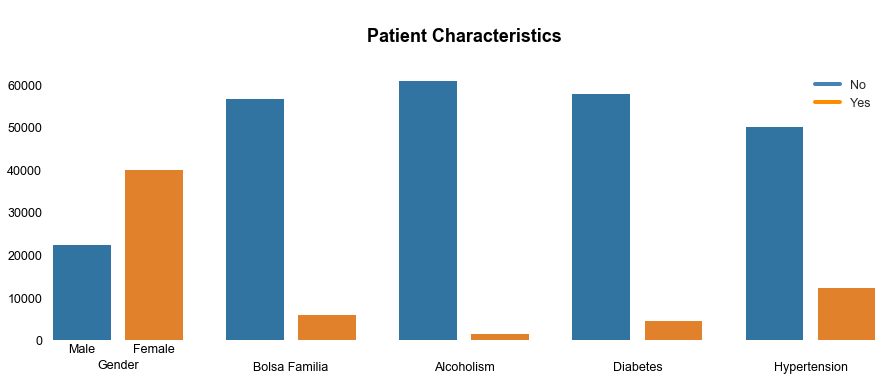

In [77]:
# Plot binary patient characteristics
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['', ''])
        ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics\n', fontsize = 18, fontweight = 'bold')
    i += 1

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [78]:
fields = ['Women', 'Bolsa Familia', 'Alcoholic', 'Diabetes', 'Hypertension']
char_props = [round(unique_patients['Gender'].mean(), 3),
              round(unique_patients['BolsaFamilia'].mean(), 3),
              round(unique_patients['Alcoholism'].mean(), 3),
              round(unique_patients['Diabetes'].mean(), 3),
              round(unique_patients['Hypertension'].mean(), 3)]

pd.DataFrame(char_props, index = fields, columns = ['Proportion'])

,Proportion
Women,0.643
Bolsa Familia,0.093
Alcoholic,0.024
Diabetes,0.071
Hypertension,0.197


In [79]:
# Average number of appointments per patient
round(df.groupby('PatientID')['AppointmentID'].count().mean(), 2)

1.63

Almost 65% of the patients in the data set are women, which fits the stereotype that men avoid going to the doctor.

#### Age

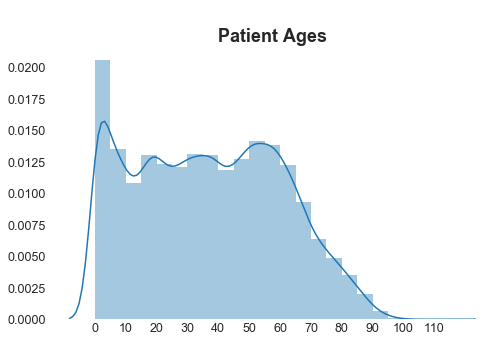

In [80]:
# Only plot the average age for each unique patient that appears in the dataset
fig = plt.figure(figsize = (8, 5))
sns.distplot(unique_patients['Age'], bins=list(range(0, 120, 5)))
sns.despine(left = True, bottom = True)
plt.title('\nPatient Ages', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.xticks(np.arange(0, 120, 10))
plt.show();

In [81]:
bins = [0, 11, 21, 41, 61, 81, 100, 116]
bin_names = ["0-10", "11-20", "21-40", "41-60", "61-80", "81-99", "100+"]

ages_bins = pd.cut(unique_patients['Age'], bins = bins, labels = bin_names).value_counts()
ages_bins.sort_index()

0-10      9984
11-20     7608
21-40    15653
41-60    16452
61-80     9130
81-99     1439
100+         4
Name: Age, dtype: int64

In [82]:
df['Age'].describe()

count    101803.000000
mean         37.059900
std          23.214054
min           0.000000
25%          18.000000
50%          37.000000
75%          56.000000
max         115.000000
Name: Age, dtype: float64

A significant number of the patients are children aged from 0 to 5.  The ages are fairly uniform from 6 to 65, after which the number of patients decreases somewhat linearly.

#### Number of Handicaps

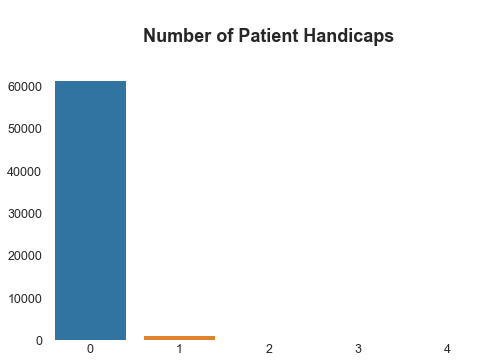

In [83]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(unique_patients['NumHandicaps'])
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['0', '1', '2', '3', '4'])
plt.show();

In [84]:
unique_patients['NumHandicaps'].value_counts()

0.0    61165
1.0     1025
2.0       99
3.0        6
4.0        3
Name: NumHandicaps, dtype: int64

In [85]:
round(unique_patients['NumHandicaps'].mean(), 3)

0.02

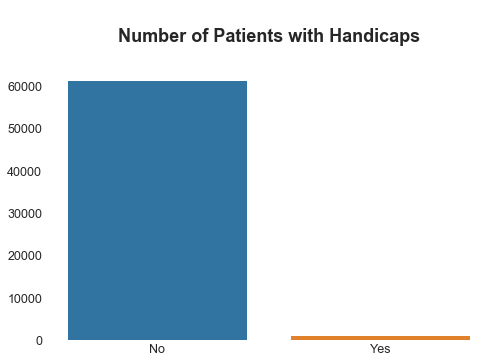

In [86]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(unique_patients['HasHandicaps'])
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Patients with Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['No', 'Yes'])
plt.show();

#### Appointments by Day

In [87]:
df['AppointmentDay'].value_counts().sort_index().resample('D').sum()

2016-04-29    2979
2016-04-30       0
2016-05-01       0
2016-05-02    4056
2016-05-03    3960
2016-05-04    3828
2016-05-05    3984
2016-05-06    3535
2016-05-07       0
2016-05-08       0
2016-05-09    4164
2016-05-10    3960
2016-05-11    4162
2016-05-12    4083
2016-05-13    3568
2016-05-14      38
2016-05-15       0
2016-05-16    4238
2016-05-17    4069
2016-05-18    4029
2016-05-19    3931
2016-05-20    3484
2016-05-21       0
2016-05-22       0
2016-05-23       0
2016-05-24    3692
2016-05-25    3566
2016-05-26       0
2016-05-27       0
2016-05-28       0
2016-05-29       0
2016-05-30    4139
2016-05-31    3956
2016-06-01    4088
2016-06-02    4014
2016-06-03    3766
2016-06-04       0
2016-06-05       0
2016-06-06    4300
2016-06-07    4098
2016-06-08    4116
Freq: D, Name: AppointmentDay, dtype: int64

There were only 38 appointments on the weekend, all occurring on Saturday, May 14th.  Besides the weekends, there were no appointments on Monday, May 23; Thursday, May 26; or Friday, May 27.

May 26 was the optional holiday of Corpus Christi, however I couldn't find any reason as to why there is no data for the 23rd or 27th.

In [88]:
df['Weekend'].sum()

38

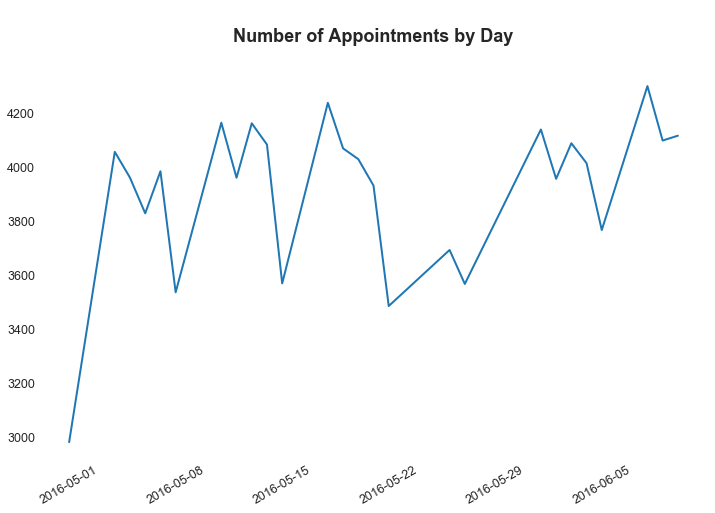

In [89]:
# Exclude weekends and weekdays with no appointments
fig = plt.figure(figsize = (12, 8))
no_weekends = df[df['Weekend'] == 0]
appt_by_day = no_weekends.groupby('AppointmentDay')['AppointmentDay'].count()
appt_by_day.plot(linewidth = 2)
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Appointments by Day\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('');

The weekends and weekdays with no appointments were excluded from the graph in order to focus more on the normal fluctuations without the low outliers affecting the graph.

In [90]:
# Average number of appointments per day (on non-zero days and weekdays)
round(df[df['Weekend'] == 0]['AppointmentDay'].value_counts().mean(), 2)

3914.04

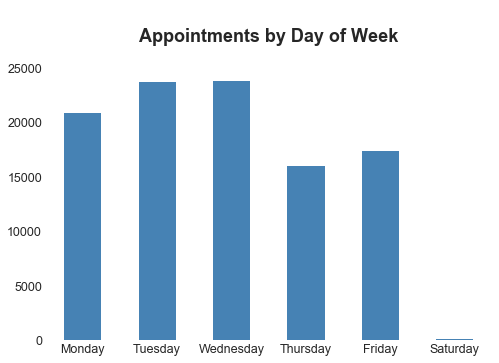

In [91]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, ax = plt.subplots(figsize = (8, 5))
df['DayOfWeek'].value_counts().sort_index().plot(ax = ax, kind = 'bar', color = 'steelblue')
ax.set(xticklabels = days_of_week)
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.title('\nAppointments by Day of Week\n', fontsize = 18, fontweight = 'bold');

The appointments started on Friday, April 29 and ended on Wednesday, June 8.  Hence there are not an equal number of weekdays in the dataset; there are appointments on five Thursdays, but six on every other weekday.  On the line graph, we can clearly see a peak occuring each Monday, and a dip occurring each Friday.  There isn't a consistent pattern for the number of appointments on Tuesdays, Wednesdays, and Thursdays, besides that they have less than or equal to Mondays, and more than Fridays.

#### Appointments By Day Scheduled

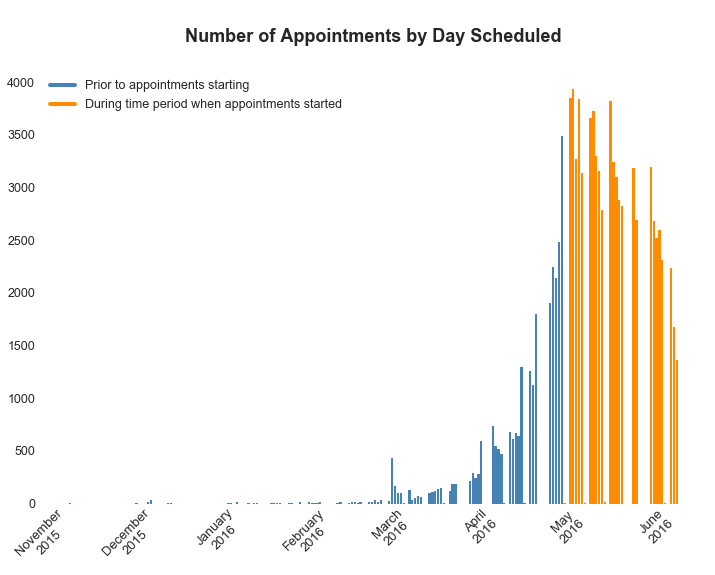

In [94]:
sched_date_counts = df.groupby('ScheduledDayDate')['ScheduledDayDate'].count()

# Find index of first scheduled date that is an appointment date
sched_len = len(sched_date_counts)
first_ix = list(sched_date_counts.index > df['AppointmentDayDate'].min()).index(True)

# Use orange for the appointments scheduled during the time period that
# the appointments took place
colors = ['steelblue'] * first_ix
colors.extend(['darkorange'] * (sched_len-first_ix))

fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(sched_date_counts.index, sched_date_counts, color = colors)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B\n%Y'))

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['Prior to appointments starting',
                         'During time period when appointments started'])

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 45, fontsize = 13)
plt.title('\nNumber of Appointments by Day Scheduled\n', fontsize = 18, fontweight = 'bold');

In [93]:
# Proportion of appointments that were scheduled during the time period that
# the appointments took place
float('{:0.3f}'.format(sched_date_counts[first_ix:].sum()/sched_date_counts.sum()))

0.736

The vast majority of appointments were made during the two weeks that the appointments were scheduled for.  Additionally, the closer to the appointments we get, the more appointments were scheduled. 

#### Appointments By Hour Scheduled

In [97]:
hour_counts = df['ScheduledHour'].value_counts()
hour_counts.sort_index()

6        25
7     10940
8     15904
9     12770
10    10841
11     9135
12     5818
13     6272
14     9015
15     7811
16     6575
17     3822
18     1865
19      755
20      230
21       25
Name: ScheduledHour, dtype: int64

In [106]:
formatted_hour = [str(hour) + ':00' for hour in hour_counts.index]
formatted_hour

['8:00',
 '9:00',
 '10:00',
 '7:00',
 '11:00',
 '14:00',
 '15:00',
 '16:00',
 '13:00',
 '12:00',
 '17:00',
 '18:00',
 '19:00',
 '20:00',
 '21:00',
 '6:00']

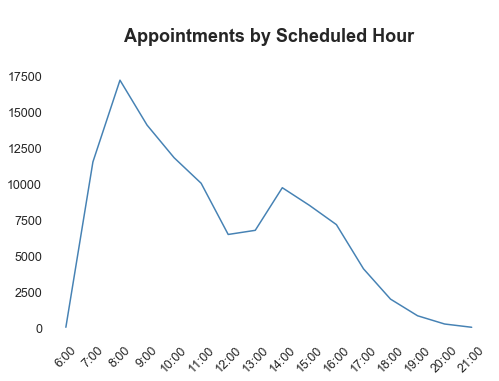

In [110]:
fig, ax = plt.subplots(figsize = (8, 5))
hour_counts.sort_index().plot(kind = 'line', color = 'steelblue')
sns.despine(left = True, bottom = True)

formatted_hours = [str(hour) + ':00' for hour in range(6, 22)]
plt.xticks(np.arange(6, 22, 1), rotation = 45)
ax.set(xticklabels=formatted_hours)
plt.title('\nAppointments by Scheduled Hour\n', fontsize = 18, fontweight = 'bold');

We can clearly see that the majority of appointments were made before 11am, with a smaller spike around 2pm, at which time it also begins monotonically decreasing.

#### Neighborhoods

In [ ]:
neighborhood_counts = df['Neighborhood'].value_counts()

fig, ax = plt.subplots(figsize = (10, 15))
neighborhood_counts.sort_values().plot(kind = 'barh', color = 'steelblue')
sns.despine(left = True, bottom = True)
plt.yticks(fontsize = 12)
plt.title('\nAppointments by Neighborhood\n', fontsize = 18, fontweight = 'bold');

There is a great discrepancy in the number of appointments in the different neighborhoods; one neighborhood has almost 7000 appointments while there are four neighborhoods with ten or fewer appointments.

In [ ]:
neighborhood_df = pd.DataFrame(neighborhood_counts).reset_index().rename(columns = {'index': 'neighborhood',
                                                                                    'Neighborhood': 'count'})
# join neighborhood_counts with geo dataframe
neighborhood_lat_lng = pd.merge(neighborhood_df, geo[['neighborhood', 'lat', 'lng']], on = 'neighborhood')

# convert counts to proportions
neighborhood_lat_lng['prop'] = neighborhood_lat_lng['count']/len(df)
neighborhood_lat_lng.head()

In [ ]:
hood_lst = neighborhood_lat_lng[['lat', 'lng', 'prop']].values.tolist() # need to pass list to folium

m = folium.Map(location=[-20.292474, -40.317893], tiles='stamentoner', zoom_start = 13)
m.add_child(folium.plugins.HeatMap(hood_lst))

#### SMS Received and No Shows

In [ ]:
# Plot binary appointment characteristics
fields = ['SMSReceived', 'NoShow']
xlabels = ['SMS Received', 'No Show']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 2, figsize = (8, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = df)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    ax.set(xticklabels=['', ''])
    ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [ ]:
# Proportion of sms received
round(df['SMSReceived'].mean(), 3)

In [ ]:
# Proportion of no shows
no_show_rate = df['NoShow'].mean()
round(no_show_rate, 3)

#### Number of Times an Appointment was Scheduled

In [ ]:
df['NumTimesScheduled'].describe()

In [ ]:
# Append missing values from value_counts index
missing_times_sched = pd.Series([0, 0], index = [7, 9])
missing_times_sched

num_times_sched = (df['NumTimesScheduled'].value_counts()).append(missing_times_sched).\
                   sort_index()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = '#2977B4')

plt.xticks(rotation = 0)
plt.ylabel('')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = '#2977B4')

plt.xticks(rotation = 0)
plt.ylabel('')
ax.set_yscale('log')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

In [ ]:
round(len(df[df['NumTimesScheduled'] == 1])/len(df), 3)

Almost 93% of the appointments were only scheduled once, but there are appointments that were rescheduled up to nine times.  The data is skewed to the right.  We can see the magnitudinal differences in the number of schedulings in the log scale plot.  The data is still skewed to the right even after the log transform.

#### Days Between Scheduling and Appointment

In [ ]:
df['DayDiff'].describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
ax.set_yscale('log')
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);
plt.show();

In [ ]:
# Proportion of appointments scheduled on the same day as the appointment
float('{:0.3f}'.format((df['DayDiff'] == 0).sum()/len(df)))

In [ ]:
### DELETE THIS LATER
day_diff_bin_labels = ['0', '1', '2', '3-5', '6-10', '11-14', '15-29', '30-59',
                       '60-99', '100+']

In [ ]:
# Create dictionary of sorting order
day_diff_sorter = dict(zip(day_diff_bin_labels, range(len(day_diff_bin_labels))))
day_diff_df = df['DayDiffBin'].value_counts().reset_index()

# Create a column of the sorting order
day_diff_df['sort_order'] = day_diff_df['index'].map(day_diff_sorter)
day_diff_df.sort_values(by = 'sort_order')
day_diff_df

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.despine(left = True, bottom = True)
sns.barplot(ax = ax, x = 'sort_order', y = 'DayDiffBin', data = day_diff_df,
           color = '#2977B4')
ax.set(xticklabels = day_diff_bin_labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 0)
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.show();

About 35% of the appointments were made on the same day as the appointment.  Very few appointments were made more than a month in advance.

#### Days Between Rescheduling

In [ ]:
df['DaysBWScheduling'].describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 30)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nDays Between Rescheduling\n', fontsize = 18, fontweight = 'bold');

From the plots of NumTimesScheduled, we know that 93% of the appointments were made once (i.e. were not rescheduled), and hence there are zero days between the original scheduling and the rescheduling of the appointment.

In [ ]:
# Differences that are greater than 0
diff_greater_0 = df.query('DaysBWScheduling > 0')['DaysBWScheduling']
diff_greater_0.describe()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
diff_greater_0.hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nNon-Zero Differences in Rescheduling\n', fontsize = 18, fontweight = 'bold');

Most of the appointments that were rescheduled were scheduled later on the same day as the original scheduling.

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
ax.set_yscale('log')
plt.title('\nDays Between Rescheduling\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

The data was skewed to the right using a normal scale, and it remains positively skewed after using a log scale.

In [ ]:
# DELETE LATER
day_bw_labels = ['0', '<1', '1', '2', '3-5', '6-10', '11-14', '15-29', '30-59', '60+']

In [ ]:
# Create dictionary of sorting order
day_bw_sorter = dict(zip(day_bw_labels, range(len(day_bw_labels))))
day_bw_df = df['DayBWBin'].value_counts().reset_index()

# Create a column of the sorting order
day_bw_df['sort_order'] = day_bw_df['index'].map(day_bw_sorter)
day_bw_df.sort_values(by = 'sort_order')
day_bw_df

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.despine(left = True, bottom = True)
sns.barplot(ax = ax, x = 'sort_order', y = 'DayBWBin',
            data = day_bw_df[1:],
            color = '#2977B4')
ax.set(xticklabels = day_bw_labels[1:])
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
plt.title('\nNon-Zero Days Between Rescheduling\n', fontsize = 18, fontweight = 'bold')
plt.show();

#### Weather

In [ ]:
# Number of rainy days
weather['rain'].sum()

In [ ]:
# Number of days with thunderstorms
weather['thunderstorm'].sum()

In [ ]:
# Number of days with fog
weather['fog'].sum()

In [ ]:
# Add field for formatted dates for plots
weather['FormattedDate'] = weather['Datetime'].dt.strftime("%B %-d")

##### Precipitation

In [ ]:
# Number of days with more than 0 in. precipitation
(weather['precip_in'] > 0).sum()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'precip_in', data = weather)
sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.ylabel('Precipitation (in.)\n', fontsize = 14)
plt.yticks(fontsize = 13)
plt.title('\nPrecipitation by Appointment Day\n', fontsize = 18, fontweight = 'bold')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()

The weather was very good during the 40-day span that the appointments took place.  There were only a few days of rain and thunderstorms, and only one day with fog.

##### Temperature

In [ ]:
# Create temps dataframe in long format for plot
temps = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['temp_high', 'temp_avg', 'temp_low'],
                var_name = 'Name',
                value_name= 'Temperature')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

custom = ['#C62D42', '#F2C649', '#0095B7']
sns.set_palette(custom)

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Temperature', hue = 'Name', data = temps)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Degrees Fahrenheit\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nTemperatures by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['temp_low'].describe(),
           weather['temp_avg'].describe(),
           weather['temp_high'].describe()],
           axis=1)

The temperature each day never got lower than 60, and was never higher than 92.  Most days the average temperature was in the mid-seventies.

##### Humidity

In [ ]:
# Create humidity dataframe in long format for plot
humidity = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['humidity_high', 'humidity_avg', 'humidity_low'],
                var_name = 'Name',
                value_name= 'Humidity')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Humidity', hue = 'Name', data = humidity)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'], loc=2)

plt.title('\nPercent Humidity by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['humidity_low'].describe(),
           weather['humidity_avg'].describe(),
           weather['humidity_high'].describe()],
           axis=1)

Humidity fluctuated a lot within each day; on some days the humidity ranged from around 30% to about 90%. Normally the humidity went from around 50% to 90%.

##### Visibility

In [ ]:
# Create humidity dataframe in long format for plot
visibility = pd.melt(weather, id_vars = ['FormattedDate'],
                     value_vars=['visibility_high', 'visibility_avg', 'visibility_low'],
                     var_name = 'Name',
                     value_name= 'Visibility')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Visibility', hue = 'Name', data = visibility)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Miles\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nVisibility by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['visibility_low'].describe(),
           weather['visibility_avg'].describe(),
           weather['visibility_high'].describe()],
           axis=1)

The visibility was always at least 2 miles, and the high was always 12 miles.  The average visibility has a lower standard deviation and was mostly from 6 to 8 miles.

##### Wind

In [ ]:
wind = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['wind_high', 'wind_avg'],
                var_name = 'Name',
                value_name= 'Wind')

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Wind', hue = 'Name', data = wind)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Miles per hour\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4)]
ax.legend(custom_lines, ['High', 'Average'], loc=2)

plt.title('\nWind by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [ ]:
pd.concat([weather['wind_avg'].describe(),
           weather['wind_high'].describe()],
           axis=1)

According to the [National Weather Service](https://www.weather.gov/bgm/forecast_terms), 15-25 mph is breezy and 20-30 mph is windy.  The average wind each day is considered "no wind," while the high is normally considered breezy. 

<a id='by_attendance'></a>

### By Attendance

In [ ]:
# Create separate dataframes for no shows and shows
no_shows = df[df['NoShow'] == 1]
shows = df[df['NoShow'] == 0]

#### Patient Characteristics & SMS Received

In [ ]:
# Plot binary patient characteristics & SMS Received by attendance - not aggregated (by individual appointment)
sns.set_palette("tab10")

fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 'SMSReceived']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension', 'SMS Received']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 6, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], hue = 'NoShow', data = df)
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics by Attendance\n', fontsize = 18, fontweight = 'bold')
    
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=8),
                Line2D([0], [0], color = 'darkorange', lw=8)]
ax.legend(custom_lines, ['Showed Up', 'No Show'])
plt.show()

In [ ]:
prop_fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 
               'SMSReceived', 'NumHandicaps', 'DayOfWeek', 'Weekend', 'Neighborhood',
               'NumTimesScheduled', 'DayDiffBin', 'DayBWBin', 'rain', 'thunderstorm',
               'fog', 'precip_in', 'humidity_high', 'humidity_avg', 'visibility_low',
               'wind_avg', 'wind_high', 'temp_high', 'temp_low', 'temp_avg', 'DayOfWeek',
               'Weekend']

# create dictionary of dataframes of proportions of no shows for each field
no_show_props = {}
for field in prop_fields:
    no_show_props[field] = (df.groupby([field,'NoShow'])['NoShow'].count()/
                            df.groupby(field)['NoShow'].count()).rename('prop').reset_index()
    no_show_props[field] = no_show_props[field][no_show_props[field]['NoShow'] == 1] # only keep no shows
    
freq_fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 
               'SMSReceived', 'rain', 'thunderstorm', 'fog']

# create dictionary of dataframes of frequencies of no shows for each field as arrays
no_show_freqs = {}
for field in freq_fields:
    counts = df.groupby([field,'NoShow'])['NoShow'].count()
    no_show_freqs[field] = np.array(counts.sort_index(ascending = False)).reshape(2,2)
    
# create dictionary of dataframes of frequencies of no shows for each field as arrays for graph labels
freqs_labels = {}
for field in prop_fields:
    counts = df.groupby([field,'NoShow'])['NoShow'].count().rename('count').reset_index()
    # only keep no shows
    counts = counts[counts['NoShow'] == 1]
    freqs_labels[field] = np.array(counts['count'])

In [ ]:
# Plot proportion of no shows by binary patient characteristics
fig, axes = plt.subplots(1, 6, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.barplot(ax = ax, x = fields[i], y = 'prop', hue = 'NoShow', data = no_show_props[fields[i]]);
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    ax.set(yticklabels='')
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\n' + ' '*30 + 'Proportion of No Shows by Patient Characteristics\n\n', fontsize = 18,
                     fontweight = 'bold')
    
    j = 0
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01,
                '{:0.3f}\nn={}'.format(height, freqs_labels[fields[i]][j]),
                ha="center")
        j +=1
    i += 1
plt.show()

#### Age

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist([no_shows['Age'].values, shows['Age'].values], bins=list(range(0, 120, 5)), normed=True)
sns.despine(left = True, bottom = True)
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=8),
                Line2D([0], [0], color = 'darkorange', lw=8)]
ax.legend(custom_lines, ['Showed Up', 'No Show'])
plt.title('\nProportion of Attendance Type by Patient Age\n', fontsize = 18, fontweight = 'bold')
plt.xticks(np.arange(0, 120, 10))
plt.show();

#### Number of Handicaps

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
sns.barplot(x = 'NumHandicaps', y = 'prop', data = no_show_props['NumHandicaps'], color = 'steelblue');
sns.despine(left = True, bottom = True)
plt.title('\nProportion of No Shows by Number of Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{:0.3f}\nn={}'.format(height, freqs_labels['NumHandicaps'][j]),
            ha="center")
    j +=1
    
plt.show();

#### Appointment Day

In [ ]:
no_shows_weekdays = no_shows[no_shows['Weekend'] == 0]
shows_weekdays = shows[shows['Weekend'] == 0]

# Number of no shows, shows by appointment day - excluding weekends
no_shows_by_day = no_shows_weekdays.groupby('AppointmentDay')['AppointmentDay'].count()
shows_by_day = shows_weekdays.groupby('AppointmentDay')['AppointmentDay'].count()

# Exclude weekends and weekdays with no appointments
fig, ax1 = plt.subplots(figsize = (12, 8))
ax2 = ax1.twinx()

ax1.plot(shows_by_day, linewidth = 2)
ax2.plot(no_shows_by_day, linewidth = 2, color = 'darkorange')

# cannot despine, it moves the second y-axis to the left
dirs = ['bottom', 'top', 'right', 'left']

for d in dirs:
    ax1.spines[d].set_color('white')
    ax2.spines[d].set_color('white')
    
plt.title('\nNumber of Shows and No Shows by Day\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'DayOfWeek', y = 'prop', data = no_show_props['DayOfWeek'], color = 'steelblue');

ax.set(xticklabels = days_of_week)
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['DayOfWeek'][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No Shows\nby Day of Week of Appointment\n', fontsize = 18, fontweight = 'bold');

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'Weekend', y = 'prop', data = no_show_props['Weekend'], color = 'steelblue');

ax.set(xticklabels = ['Weekday', 'Weekend'])
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['Weekend'][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No Shows\nby Weekday and Weekend\n', fontsize = 18, fontweight = 'bold');

#### Neighborhood

In [ ]:
no_show_props['Neighborhood'] = no_show_props['Neighborhood'].sort_values(by = 'prop', ascending = False)

fig, ax = plt.subplots(figsize = (10, 15))
sns.barplot(x = 'prop', y = 'Neighborhood', data = no_show_props['Neighborhood'], color = 'steelblue');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('')
    
plt.title('\nProportion of No Shows\nby Neighborhood\n', fontsize = 18, fontweight = 'bold');

In [ ]:
# there were only two appointments at this location and they were both no shows
df[df['Neighborhood'] == 'ILHAS OCEÂNICAS DE TRINDADE']

In [ ]:
# Do not include ILHAS OCEÂNICAS DE TRINDADE in plot
no_show_props_to_plot = no_show_props['Neighborhood'][no_show_props['Neighborhood']\
                                                      ['Neighborhood'] != 'ILHAS OCEÂNICAS DE TRINDADE']
no_show_props_to_plot = no_show_props_to_plot.sort_values(by = 'prop', ascending = False)

fig, ax = plt.subplots(figsize = (10, 15))
sns.barplot(x = 'prop', y = 'Neighborhood', data = no_show_props_to_plot, color = 'steelblue');

sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0, 0.35, 0.05))
plt.axvline(x=no_show_rate, color = 'gold')

plt.title('\nProportion of No Shows\nby Neighborhood\n', fontsize = 18, fontweight = 'bold');

#### Days Between Scheduling and Appointment

In [ ]:
# Create a column for the sorting order
no_show_props['DayDiffBin']['sort_order'] = no_show_props['DayDiffBin']['DayDiffBin'].map(day_diff_sorter)
no_show_props['DayDiffBin'].sort_values(by = 'sort_order')
no_show_props['DayDiffBin']

fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'sort_order', y = 'prop', data = no_show_props['DayDiffBin'], color = 'steelblue');
ax.set(xticklabels=day_diff_bin_labels)

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0
# sorter list for the count labels
day_diff_sorter_list = [0, 1, 5, 6, 8, 3, 4, 7, 9, 2]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['DayDiffBin'][day_diff_sorter_list][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No Shows\nby Number of Days Between Scheduling and Appointment\n',
          fontsize = 18, fontweight = 'bold');

#### Number of Times an Appointment was Scheduled

In [ ]:
no_show_props['NumTimesScheduled']

In [ ]:
df[df['NumTimesScheduled'] >= 8]

There is only one appointment that was scheduled eight times, and the patient did not show up for it.  Hence this record was excluded from the plot, in order to better focus on the differences in proportions for the other number of times scheduled.

There was also one appointment that scheduled ten times that the patient showed up for.  This was also excluded from the plot since a sample size of one is not adequate to use to make conclusions.

In [ ]:
num_sched_to_plot = no_show_props['NumTimesScheduled'][no_show_props['NumTimesScheduled']['NumTimesScheduled'] <= 6]

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'NumTimesScheduled', y = 'prop', data = num_sched_to_plot, color = 'steelblue');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['NumTimesScheduled'][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No Shows\nby Number of Times Scheduled\n',
          fontsize = 18, fontweight = 'bold');

#### Days Between Rescheduling

In [ ]:
# Create a column for the sorting order
no_show_props['DayBWBin']['sort_order'] = no_show_props['DayBWBin']['DayBWBin'].map(day_bw_sorter)
no_show_props['DayBWBin'].sort_values(by = 'sort_order')
no_show_props['DayBWBin']

fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'sort_order', y = 'prop', data = no_show_props['DayBWBin'], color = 'steelblue');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=day_bw_labels)
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')
j = 0

day_bw_sorter_list = [0, 9, 1, 4, 5, 7, 2, 3, 6, 8]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['DayBWBin'][day_bw_sorter_list][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No Shows\nby Days Between Rescheduling\n',
          fontsize = 18, fontweight = 'bold');